# Torque model

This example studies the causes of leakage of a mechanical model.

It has several parameters: Torque (T), Joint (J), Angle (A), Vibration (V) and Leak (L).

In [20]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import openturns as ot
import otagrum
import numpy as np

**Probabilistic model**

In [21]:
# Marginal distributions
Torque = ot.LogNormal(0.0, 0.25)
Angle = ot.TruncatedNormal(0.0, 2.0, -8.0, 8.0)
Joint = ot.Uniform(1.8, 2.2)

# Dependence
rho = 0.5
TorqueAngleCopula = ot.NormalCopula(ot.CorrelationMatrix(2, [1.0, rho, rho, 1.0]))
copula = ot.ComposedCopula([TorqueAngleCopula, ot.IndependentCopula(1)])

# Joint distribution if needed
TorqueAngle = ot.ComposedDistribution([Torque, Angle], TorqueAngleCopula)
fullDistribution = ot.ComposedDistribution([Torque, Angle, Joint], copula)

# Leakage angle (rd)
angleMax = 5.0

# Leakage joint (mm)
jointMin = 2.0
jointSpread = 0.1

# Vibration torque (kN.m)
torqueSpread = 2.0


**(Discrete) Graphical model**

In [ ]:
n_ticks = 100
nodes = 16


def completeTicks(range,ticks):
    if range is None:
        return [float("-inf")]+ticks+[float("inf")]
    else:
        return [range.getLowerBound()[0]] + ticks + [range.getUpperBound()[0]]


torque_ticks = [
    (n_ticks - i) * Torque.getRange().getLowerBound()[0] / (n_ticks + 1) +
    (i + 1.0) * Torque.getRange().getUpperBound()[0] / (n_ticks + 1)
    for i in range(n_ticks)
]

angle_ticks = [(n_ticks - i) * Angle.getRange().getLowerBound()[0] /
               (n_ticks + 1) +
               (i + 1.0) * Angle.getRange().getUpperBound()[0] / (n_ticks + 1)
               for i in range(n_ticks)]

joint_ticks = [(n_ticks - i) * Joint.getRange().getLowerBound()[0] /
               (n_ticks + 1) +
               (i + 1.0) * Joint.getRange().getUpperBound()[0] / (n_ticks + 1)
               for i in range(n_ticks)]

vibration_ticks = [-1.0, -0.5, 0.0, 0.5, 1.0]

bn = gum.BayesNet()
bn.add(gum.DiscretizedVariable("T", "Torque", completeTicks(Torque.getRange(),torque_ticks)))
bn.add(gum.DiscretizedVariable("A", "Angle", completeTicks(Angle.getRange(),angle_ticks)))
bn.add(gum.DiscretizedVariable("J", "Joint", completeTicks(Joint.getRange(),joint_ticks)))

bn.add(
    gum.DiscretizedVariable("V", "Vibration", completeTicks(None,vibration_ticks)))
bn.add(gum.LabelizedVariable("L", "Leak", ["False", "True"]))

bn.addArc("T", "V")
bn.addArc("T", "A")
bn.addArc("J", "V")
bn.addArc("J", "L")
bn.addArc("A", "L")
bn

**Discretizations**

In [24]:

# This function allows to discretize a conditional distribution of X_d knowing X_1,...,X_{d-1} from a joint distribution of (X_1,...,X_d) and a discretization grid.
def discretizeFromJoint(fullDistribution, ticks):
    fullDimension = fullDistribution.getDimension()
    conditioningDistribution = fullDistribution.getMarginal([i for i in range(fullDimension-1)])
    # Add the range bounds to the given ticks
    lower = fullDistribution.getRange().getLowerBound()
    upper = fullDistribution.getRange().getUpperBound()
    expandedTicks = [0]*len(ticks)
    for i in range(fullDimension):
        expandedTicks[i] = [lower[i]] + ticks[i] + [upper[i]]
    # Now perform the full discretization
    lengths = [(len(t)-1) for t in expandedTicks]
    tuples = ot.Tuples(lengths).generate()
    probabilities = ot.Point(len(tuples))
    for i in range(len(tuples)):
        tuple = tuples[i]
        aFull = [expandedTicks[j][tuple[j]] for j in range(fullDimension)]
        bFull = [expandedTicks[j][tuple[j]+1] for j in range(fullDimension)]
        aConditioning = [expandedTicks[j][tuple[j]] for j in range(fullDimension-1)]
        bConditioning = [expandedTicks[j][tuple[j]+1] for j in range(fullDimension-1)]
        den = conditioningDistribution.computeProbability(ot.Interval(aConditioning, bConditioning))
        if den > 0.0:
            num = fullDistribution.computeProbability(ot.Interval(aFull, bFull))
            probabilities[i] = num / den
    return probabilities

# This function allows to discretize a conditional distribution knowing its conditional density function given as a Function, its conditioning distribution and a discretization grid. WARNING: The result is NOT normalized
def discretizeFromConditionalDensity(conditionalDensity, conditioningDistribution, ticks, useSlowIntegration=True, nodesNumber=32):
    fullDimension = conditioningDistribution.getDimension() + 1
    if useSlowIntegration:
        # Accurate but slow
        integrator = ot.IteratedQuadrature()
    else:
        # Less accurate for non-smooth integrand but fast
        ot.ResourceMap.SetAsUnsignedInteger("GaussLegendre-DefaultMarginalIntegrationPointsNumber", nodesNumber)
        integrator = ot.GaussLegendre(fullDimension)
    # Add the range bounds to the given ticks
    lower = list(conditioningDistribution.getRange().getLowerBound())
    upper = list(conditioningDistribution.getRange().getUpperBound())
    # For the conditioned variable it has to be estimated. We assume that the given
    # tick range is a correct margin to get the lower and upper bounds
    conditionedMin = min(ticks[fullDimension - 1])
    conditionedMax = max(ticks[fullDimension - 1])
    delta = conditionedMax - conditionedMin
    lower = lower + [conditionedMin - delta]
    upper = upper + [conditionedMax + delta]
    expandedTicks = [0]*fullDimension
    for i in range(fullDimension):
        expandedTicks[i] = [lower[i]] + ticks[i] + [upper[i]]
    # Now perform the full discretization
    lengths = [(len(t)-1) for t in expandedTicks]
    tuples = ot.Tuples(lengths).generate()
    probabilities = ot.Point(len(tuples))

    def kernel(x):
        x = np.array(x)
        return conditionalDensity(x) * np.array(conditioningDistribution.computePDF(x[:,0:fullDimension-1]))

    for i in range(len(tuples)):
        tuple = tuples[i]
        aFull = [expandedTicks[j][tuple[j]] for j in range(fullDimension)]
        bFull = [expandedTicks[j][tuple[j]+1] for j in range(fullDimension)]
        
        num = integrator.integrate(ot.PythonFunction(fullDimension, 1, func_sample=kernel), ot.Interval(aFull, bFull))[0]
        probabilities[i] = num
    return probabilities
    
# This function allows to discretize a conditional Bernoulli distribution knowing its conditional probability function given as a Function, its conditioning distribution and a conditional discretization grid.
def discretizeBernoulliFromConditionalProbability(conditionalProbability, conditioningDistribution, ticks, useSlowIntegration=True, nodesNumber=32):
    conditioningDimension = conditioningDistribution.getDimension()
    if useSlowIntegration:
        # Accurate but slow
        integrator = ot.IteratedQuadrature()
    else:
        # Less accurate for non-smooth integrand but fast
        ot.ResourceMap.SetAsUnsignedInteger("GaussLegendre-DefaultMarginalIntegrationPointsNumber", nodesNumber)
        integrator = ot.GaussLegendre(conditioningDimension)
    # Less accurate for non-smooth integrand but fast
    ot.ResourceMap.SetAsUnsignedInteger("GaussLegendre-DefaultMarginalIntegrationPointsNumber", 32)
    integrator = ot.GaussLegendre(conditioningDimension)
    # Add the range bounds to the given ticks
    lower = list(conditioningDistribution.getRange().getLowerBound())
    upper = list(conditioningDistribution.getRange().getUpperBound())
    # Add the range bounds to the given ticks
    lower = conditioningDistribution.getRange().getLowerBound()
    upper = conditioningDistribution.getRange().getUpperBound()
    expandedTicks = [0]*len(ticks)
    for i in range(conditioningDimension):
        expandedTicks[i] = [lower[i]] + ticks[i] + [upper[i]]
    # Now perform the full discretization
    lengths = [(len(t)-1) for t in expandedTicks]
    tuples = ot.Tuples(lengths).generate()
    probabilitiesTrue = [0]*len(tuples)

    def kernel(x):
        x = np.array(x)
        return conditionalProbability(x) * np.array(conditioningDistribution.computePDF(x[:,0:conditioningDimension]))

    for i in range(len(tuples)):
        tuple = tuples[i]
        aConditioning = [expandedTicks[j][tuple[j]] for j in range(conditioningDimension)]
        bConditioning = [expandedTicks[j][tuple[j]+1] for j in range(conditioningDimension)]
        den = conditioningDistribution.computeProbability(ot.Interval(aConditioning, bConditioning))
        if den > 0.0:
            num = integrator.integrate(ot.PythonFunction(conditioningDimension, 1, func_sample=kernel), ot.Interval(aConditioning, bConditioning))[0]
            probabilitiesTrue[i] = min(1.0, num / den)
        probabilities = ot.Point([1.0 - p for p in probabilitiesTrue] + probabilitiesTrue)
    return probabilities

In [27]:
# Discretization of everything

# Compute P(Leakage = True | Angle = angle, Joint = joint)
def P_LeakageKnowingAngleAndJoint(x):
    x = np.array(x)
    angle = x[:, 0]
    joint = x[:, 1]
    s = (1, x.shape[0])
    sp = (x.shape[0], 1)
    one = np.ones(s)
    return (np.minimum(np.abs(angle / angleMax), one) * np.minimum(
        one, np.exp(-(joint - jointMin) / jointSpread))).reshape(sp)


# Compute K.p(Vibration = v | Torque = torque, Joint = joint) where K is unknown
def f_VibrationKnowingTorqueAndJoint(x):
    x = np.array(x)
    joint = x[:, 0]
    torque = x[:, 1]
    jointRed = joint / jointSpread
    torqueRed = torque / torqueSpread
    return ((1.0 + jointRed**2 + torqueRed**2)**(-4.0)).reshape(x.shape[0], 1)


AngleKnowingTorque = discretizeFromJoint(TorqueAngle,
                                         [torque_ticks, angle_ticks])

LeakageKnowingAngleAndJoint = discretizeBernoulliFromConditionalProbability(
    P_LeakageKnowingAngleAndJoint, ot.ComposedDistribution([Angle, Joint]),
    [angle_ticks, joint_ticks], False, nodes)

VibrationKnowingTorqueAndJoint = discretizeFromConditionalDensity(
    f_VibrationKnowingTorqueAndJoint, ot.ComposedDistribution([Torque, Joint]),
    [torque_ticks, joint_ticks, vibration_ticks], False, nodes)


**Discretized Parameters for the BN**

In [29]:
bn.cpt("J").fillWith(otagrum.Utils.Discretize(Torque, bn.variable("J").toDiscretizedVar()))
bn.cpt("T").fillWith(otagrum.Utils.Discretize(Torque, bn.variable("T").toDiscretizedVar()))

bn.cpt("A").fillWith(list(AngleKnowingTorque)).normalizeAsCPT()

p=gum.Potential().add(bn.variable("J")).add(bn.variable("A")).add(bn.variable("L"))
p.fillWith(list(LeakageKnowingAngleAndJoint))
s=bn.cpt("L").var_names
s.reverse()
p.reorganize(s)
bn.cpt("L").fillWith(p)

p=gum.Potential().add(bn.variable("J")).add(bn.variable("T")).add(bn.variable("V"))
p.fillWith(list(VibrationKnowingTorqueAndJoint))
s=bn.cpt("V").var_names
s.reverse()
p.reorganize(s)
bn.cpt("V").fillWith(p).normalizeAsCPT()
gnb.showInformation(bn)


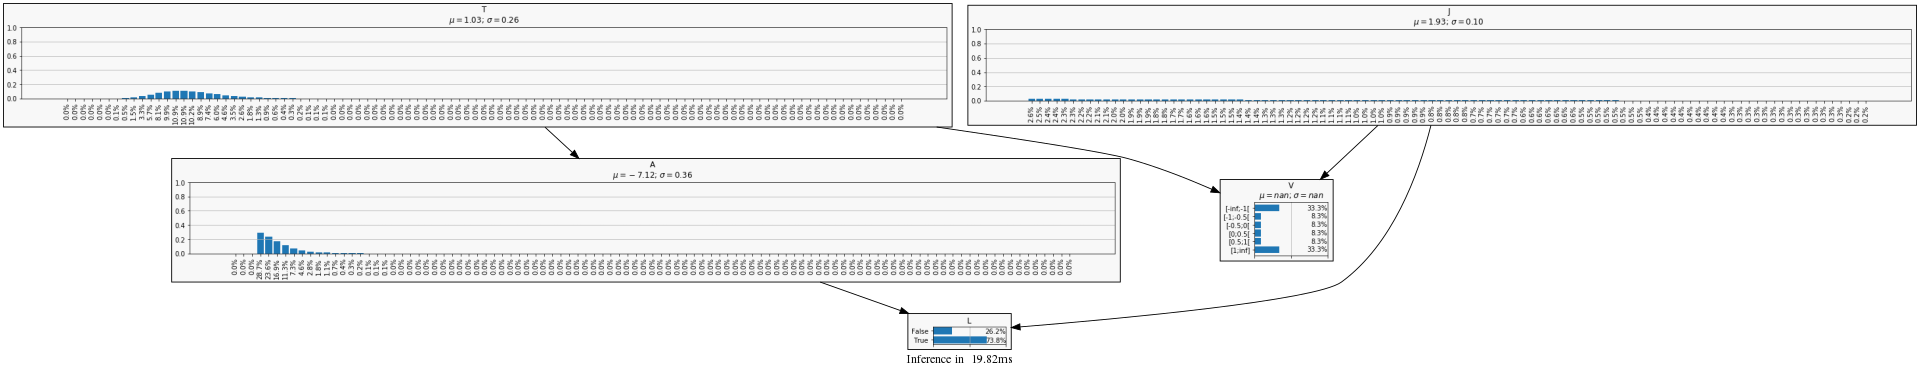

In [30]:
gnb.showInference(bn,size="20")

In [ ]:
gnb.showInference(bn,evs={"L":True},size="20")

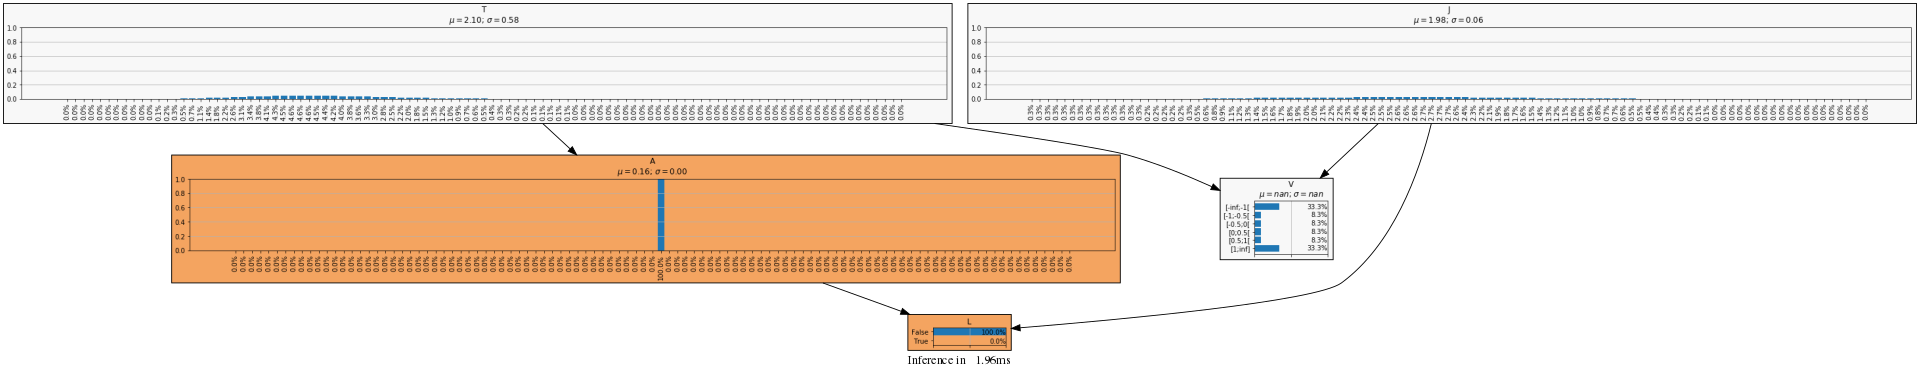

In [31]:
gnb.showInference(bn,evs={"L":False,"A":"0.2"},size="20")

In [37]:
ie=gum.LazyPropagation(bn)
ie.addJointTarget(["T","J"])
ie.setEvidence({"L":True})
ie.makeInference()

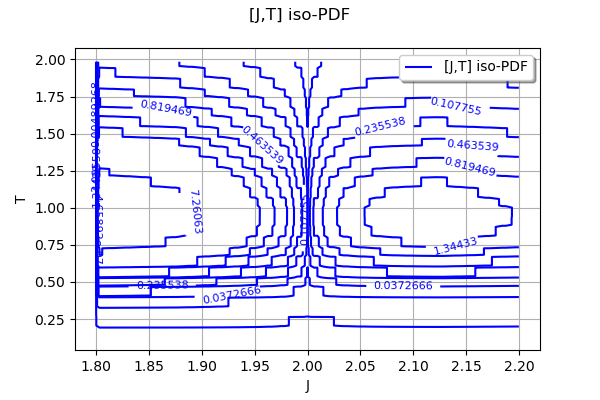

In [38]:
distrib=otagrum.Utils.FromPotential(ie.jointPosterior(["T", "J"]))
distrib.drawPDF()

In [39]:
ie=gum.LazyPropagation(bn)
ie.addJointTarget(["T","J"])
ie.setEvidence({"L":False})
ie.makeInference()

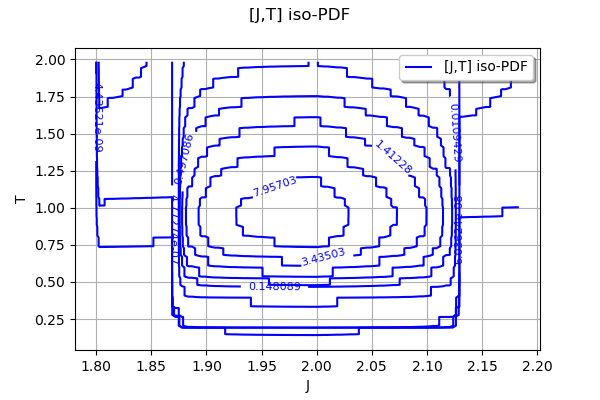

In [40]:
distrib=otagrum.Utils.FromPotential(ie.jointPosterior(["T","J"]))
distrib.drawPDF()